<a href="https://colab.research.google.com/github/michalkrzyzanowski2001/week19/blob/main/week19prac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2


In [ ]:
!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O "/tmp/cats-and-dogs.zip"

--2024-07-04 18:13:01--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.252.210, 2600:1417:3f:138a::317f, 2600:1417:3f:1388::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.36.252.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   253MB/s    in 3.1s    

2024-07-04 18:13:04 (253 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [ ]:
def get_valid(file_path):
    correct_files = []
    for name in os.listdir(file_path):
        try:
            img = Image.open(file_path + "/" + name)
            correct_files.append(name)
        except UnidentifiedImageError:
            pass
    return correct_files

In [ ]:
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
classes = ['Cat', 'Dog']
original_cat_path = '/tmp/PetImages/Cat'
original_dog_path = '/tmp/PetImages/Dog'
original_cat = get_valid(original_cat_path)
original_dog = get_valid(original_dog_path)
random.seed(101)

random.shuffle(original_cat)
random.shuffle(original_dog)
size = min(len(original_cat), len(original_dog))
train_size = int(np.floor(0.7 * size))

valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size
base_directory = 'dataset'
os.mkdir(base_directory)
type_datasets = ['train', 'valid', 'test']
directories = {}

for type_dataset in type_datasets:
    directory = os.path.join(base_directory, type_dataset)
    os.mkdir(directory)
    for name_class in classes:
        animal = os.path.join(directory, name_class)
        os.mkdir(animal)
        directories[f'{type_dataset}_{name_class}'] = animal+'/'
index = 0

for name_cat, name_dog in zip(original_cat, original_dog):
        if index <= train_size:
            type_of_dataset = 'train'
        elif train_size < index <= (train_size + valid_size):
            type_of_dataset = 'valid'
        elif (train_size + valid_size) < index <= (train_size + valid_size + test_size):
            type_of_dataset = 'test'
        shutil.copyfile(src=(original_cat_path + '/' +name_cat), dst=(directories[f'{type_of_dataset}_Cat']+name_cat))
        shutil.copyfile(src=(original_dog_path + '/' + name_dog), dst=(directories[f'{type_of_dataset}_Dog']+name_dog))
        index += 1

print(f'Dog - train: {len(os.listdir(directories["train_Dog"]))}\tCat - train: {len(os.listdir(directories["train_Cat"]))}')
print(f'Dog - valid: {len(os.listdir(directories["valid_Dog"]))}\tCat - valid: {len(os.listdir(directories["valid_Cat"]))}')
print(f'Dog - test:  {len(os.listdir(directories["test_Dog"]))}\tCat - test:  {len(os.listdir(directories["test_Cat"]))}')

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Dog - train: 8750	Cat - train: 8750
Dog - valid: 2499	Cat - valid: 2499
Dog - test:  1250	Cat - test:  1250


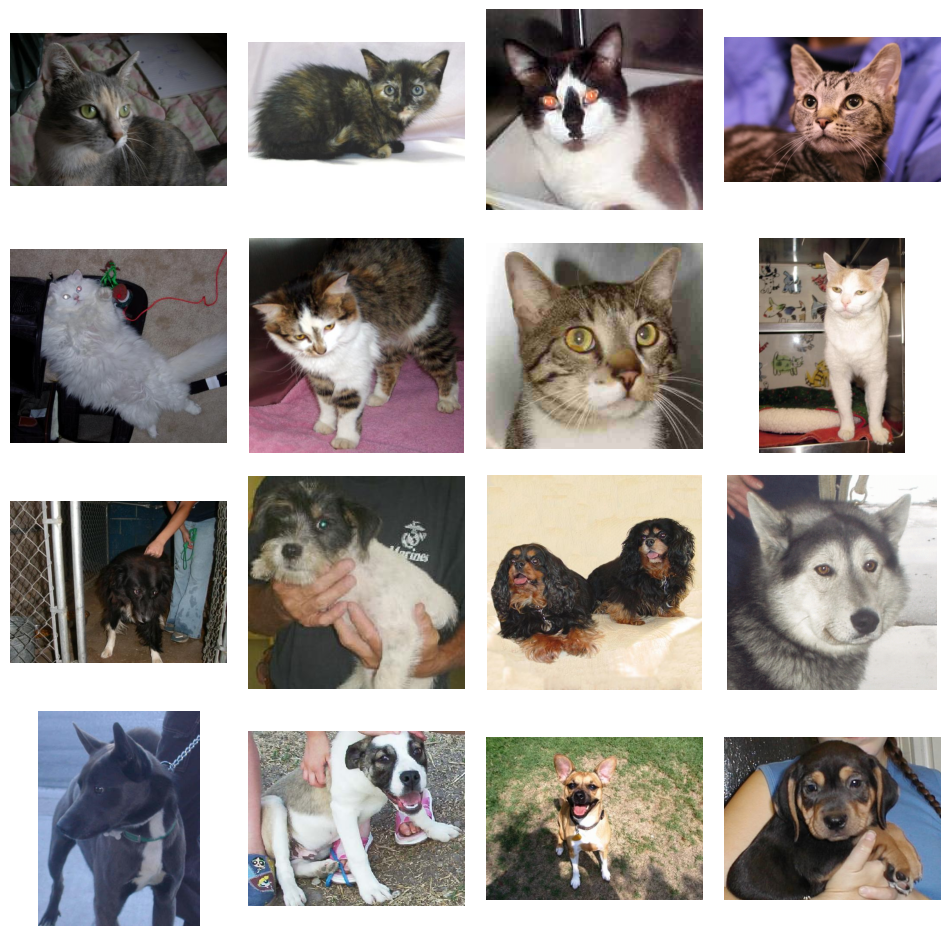

In [ ]:
fig = plt.figure(figsize = (12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, element in enumerate(os.listdir(os.path.join(directories["train_Cat"]))[:8]):
    ax = fig.add_subplot(4, 4, i+1)
    img = Image.open(directories["train_Cat"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, element in enumerate(os.listdir(os.path.join(directories["train_Dog"]))[:8]):
    ax = fig.add_subplot(4, 4, i+9)
    img = Image.open(directories["train_Dog"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_width, img_height = 150, 150
train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/valid/'
epochs = 1000
batch_size = 64
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size
patience = 5
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size, class_mode='binary')
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   horizontal_flip=True)
train_generator_augmentation = train_datagen_augmentation.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')

Found 17500 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.


In [ ]:
models = []
os.mkdir("history")
os.mkdir("charts")

In [ ]:
model_baseline = Sequential()
model_baseline.add(Flatten(input_shape=(150, 150, 3)))
model_baseline.add(Dense(units=1, activation='sigmoid'))
model_baseline.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_baseline.summary()
models.append("baseline")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 1)                 67501     
                                                                 
Total params: 67501 (263.68 KB)
Trainable params: 67501 (263.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True)

In [ ]:
history_baseline = model_baseline.fit_generator(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])
history_baseline_df = pd.DataFrame(history_baseline.history)
history_baseline_csv_file = 'history/history_baseline.csv'

with open(history_baseline_csv_file, mode='w') as f:
    history_baseline_df.to_csv(f)

<ipython-input-12-01c73b621099>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_baseline = model_baseline.fit_generator(train_generator,


Epoch 1/1000
136/136 [==============================] - 26s 183ms/step - loss: 0.9899 - accuracy: 0.4966 - val_loss: 0.8965 - val_accuracy: 0.5104
Epoch 2/1000
136/136 [==============================] - 39s 288ms/step - loss: 0.9138 - accuracy: 0.5208 - val_loss: 1.0358 - val_accuracy: 0.5092
Epoch 3/1000
136/136 [==============================] - 29s 216ms/step - loss: 0.9184 - accuracy: 0.5309 - val_loss: 0.8574 - val_accuracy: 0.5140
Epoch 4/1000
136/136 [==============================] - 30s 218ms/step - loss: 0.9072 - accuracy: 0.5333 - val_loss: 0.8683 - val_accuracy: 0.4984
Epoch 5/1000
136/136 [==============================] - 31s 230ms/step - loss: 0.9161 - accuracy: 0.5301 - val_loss: 0.6715 - val_accuracy: 0.5998
Epoch 6/1000
136/136 [==============================] - 27s 201ms/step - loss: 0.8926 - accuracy: 0.5438 - val_loss: 0.7208 - val_accuracy: 0.5541
Epoch 7/1000
136/136 [==============================] - 26s 189ms/step - loss: 0.9062 - accuracy: 0.5360 - val_loss: 0

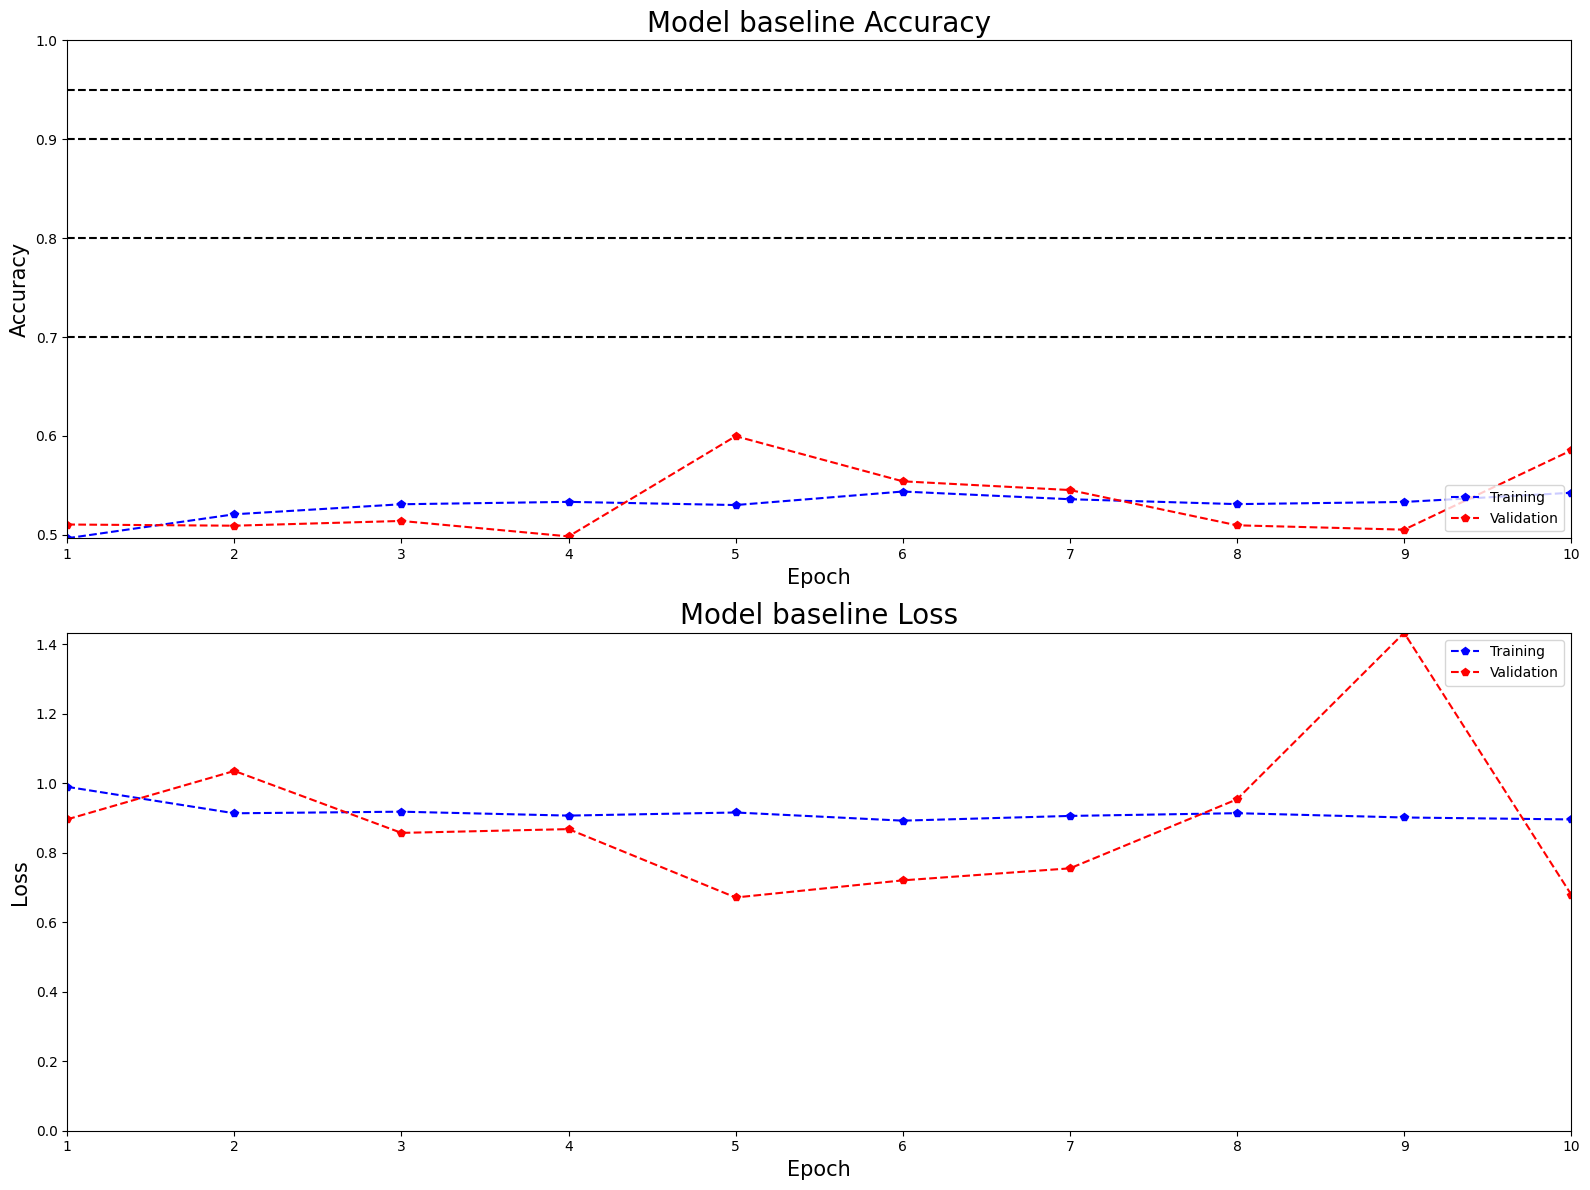

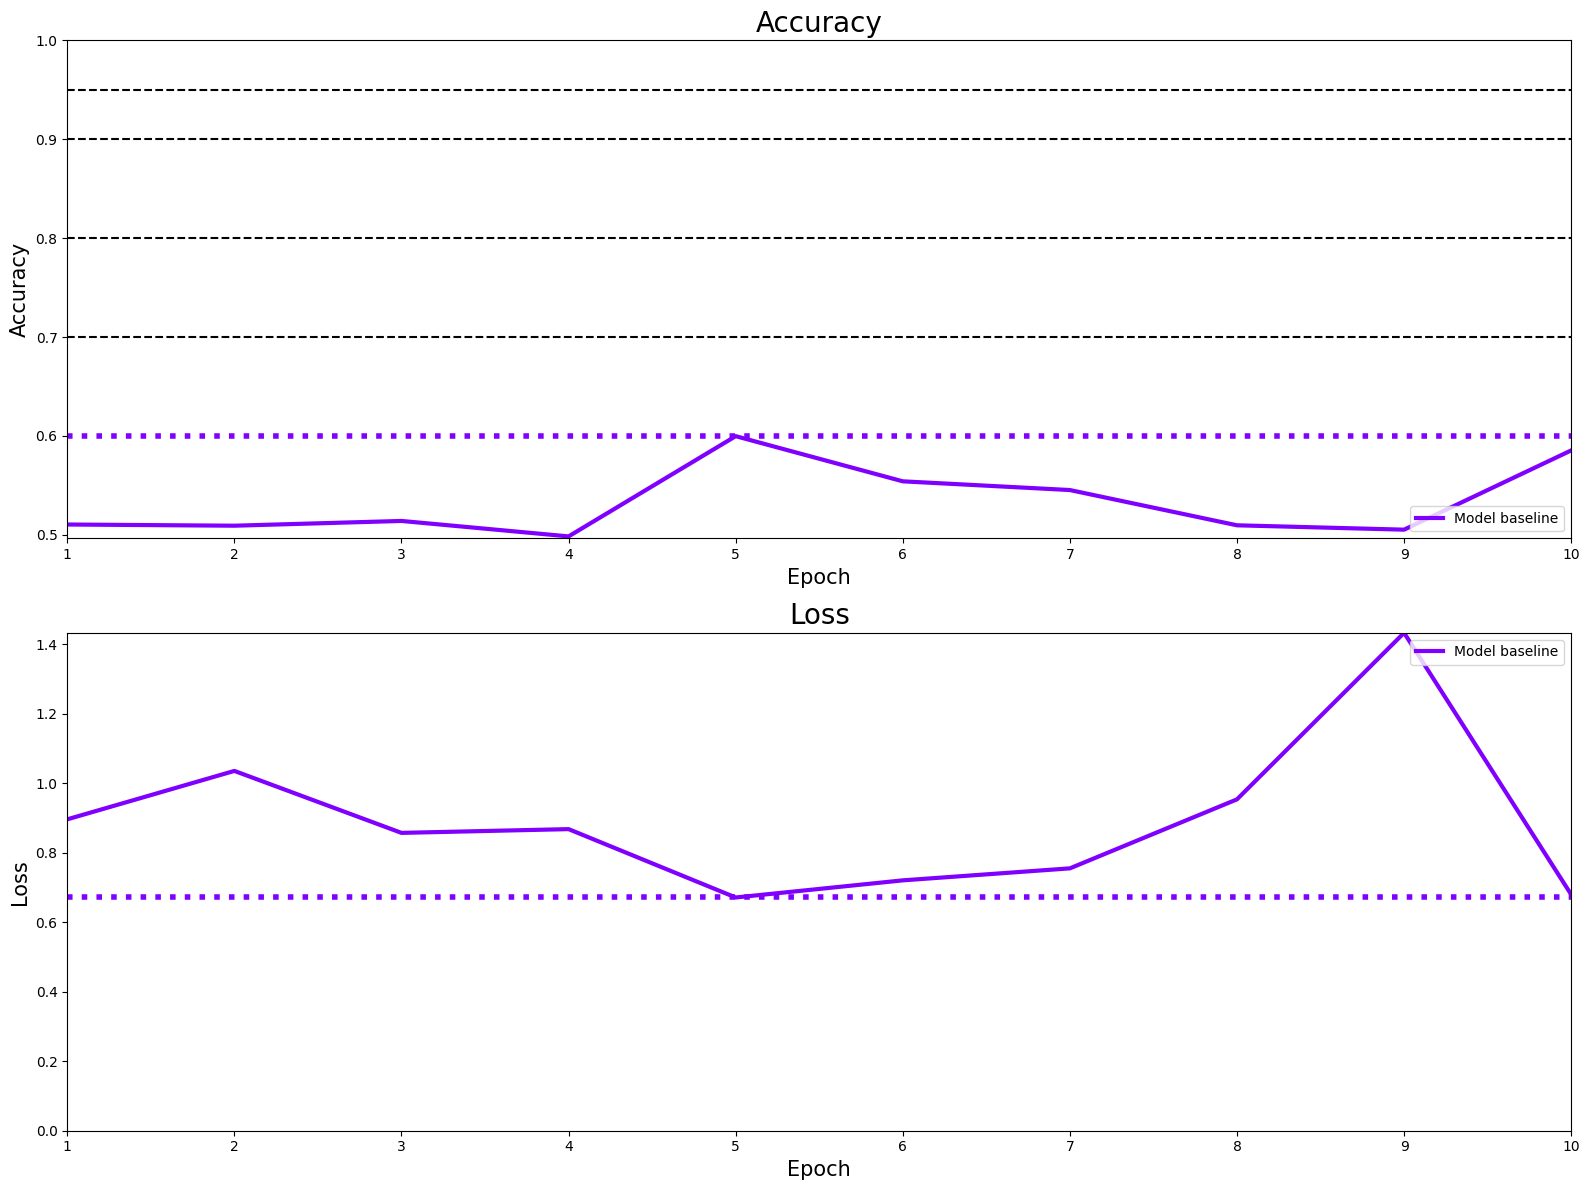

In [ ]:
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    if max_index < max(df.index):
        max_index = max(df.index)
    if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
        min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
    if max_loss < max(df[['loss', 'val_loss']].max()):
        max_loss = max(df[['loss', 'val_loss']].max())

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(211)
    ax.plot(df['accuracy'], "bp--")
    ax.plot(df['val_accuracy'], "rp--")
    ax.set_title(f'Model {model} Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])

    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
        try:
            if min(df[df['val_accuracy'] >= milestone].index) > 1:
                plt.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                ax.text(min(df[df['val_accuracy'] >= milestone].index)+0.6, min_accuracy+0.02,
                        f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
        except:
            pass

    plt.legend(['Training', 'Validation'], loc='lower right')
    ax = fig.add_subplot(212)
    ax.plot(df['loss'], "bp--")
    ax.plot(df['val_loss'], "rp--")
    ax.set_title(f'Model {model} Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model}.png', transparent=True, dpi=600)
    plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
plt.legend(loc='lower right')
ax = fig.add_subplot(212)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)
ax.set_title(f'Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)
plt.show()

In [ ]:
model_simple_1 = Sequential()
model_simple_1.add(Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model_simple_1.add(MaxPooling2D(2, 2))
model_simple_1.add(Flatten())
model_simple_1.add(Dense(units=1, activation='sigmoid'))
model_simple_1.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_1.summary()
models.append("simple_1")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 10)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 54760)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 54761     
                                                                 
Total params: 55041 (215.00 KB)
Trainable params: 55041 (215.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_simple_1 = model_simple_1.fit_generator(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_1_df = pd.DataFrame(history_simple_1.history)
history_simple_1_csv_file = 'history/history_simple_1.csv'

with open(history_simple_1_csv_file, mode='w') as f:
    history_simple_1_df.to_csv(f)

<ipython-input-15-6c301ea871ea>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_simple_1 = model_simple_1.fit_generator(train_generator,


Epoch 1/1000
136/136 [==============================] - 112s 817ms/step - loss: 0.6742 - accuracy: 0.6110 - val_loss: 0.6006 - val_accuracy: 0.6739
Epoch 2/1000
 56/136 [===========>..................] - ETA: 50s - loss: 0.5752 - accuracy: 0.7026

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 [==============================] - 109s 799ms/step - loss: 0.5776 - accuracy: 0.6944 - val_loss: 0.5888 - val_accuracy: 0.6807
Epoch 3/1000
136/136 [==============================] - 112s 816ms/step - loss: 0.5267 - accuracy: 0.7409 - val_loss: 0.5583 - val_accuracy: 0.7175
Epoch 4/1000
136/136 [==============================] - 106s 783ms/step - loss: 0.4984 - accuracy: 0.7683 - val_loss: 0.5430 - val_accuracy: 0.7204
Epoch 5/1000
136/136 [==============================] - 101s 742ms/step - loss: 0.4652 - accuracy: 0.7847 - val_loss: 0.5441 - val_accuracy: 0.7328
Epoch 6/1000
136/136 [==============================] - 106s 782ms/step - loss: 0.4459 - accuracy: 0.7970 - val_loss: 0.5465 - val_accuracy: 0.7376
Epoch 7/1000
136/136 [==============================] - 102s 748ms/step - loss: 0.4233 - accuracy: 0.8133 - val_loss: 0.5694 - val_accuracy: 0.7276
Epoch 8/1000
136/136 [==============================] - 104s 768ms/step - loss: 0.4063 - accuracy: 0.8245 - val_loss: 0.5522 

In [ ]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = True

set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg16.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

model_4 = Sequential()
model_4.add(vgg16)
model_4.add(Flatten())
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(units=1, activation='sigmoid'))
model_4.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(lr=1e-4),
                       metrics=['accuracy'])
model_4.summary()
models.append("model_4")

58889256/58889256 [==============================] - 3s 0us/step


layer_name: input_1       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (Non

In [ ]:
model4test = model_4.fit_generator(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])
model4_df = pd.DataFrame(model4test.history)
model4_csv_file = 'history/model4test.csv'

with open(model4_csv_file, mode='w') as f:
    model4_df.to_csv(f)

<ipython-input-17-a13c6dad8715>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model4test = model_4.fit_generator(train_generator,


Epoch 1/1000
 61/136 [============>.................] - ETA: 25:08 - loss: 1.0596 - accuracy: 0.4884

KeyboardInterrupt: 

In [ ]:
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    if max_index < max(df.index):
        max_index = max(df.index)
    if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
        min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
    if max_loss < max(df[['loss', 'val_loss']].max()):
        max_loss = max(df[['loss', 'val_loss']].max())

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(211)
    ax.plot(df['accuracy'], "bp--")
    ax.plot(df['val_accuracy'], "rp--")
    ax.set_title(f'Model {model} Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])

    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
        try:
            if min(df[df['val_accuracy'] >= milestone].index) > 1:
                plt.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                ax.text(min(df[df['val_accuracy'] >= milestone].index)+0.6, min_accuracy+0.02,
                        f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
        except:
            pass

    plt.legend(['Training', 'Validation'], loc='lower right')
    ax = fig.add_subplot(212)
    ax.plot(df['loss'], "bp--")
    ax.plot(df['val_loss'], "rp--")
    ax.set_title(f'Model {model} Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model}.png', transparent=True, dpi=600)
    plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
plt.legend(loc='lower right')
ax = fig.add_subplot(212)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)
ax.set_title(f'Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)
plt.show()

In [ ]:
model_5 = Sequential()
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Flatten())
model_5.add(Dropout(0.5))
model_5.add(Dense(256, activation='relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(128, activation='relu'))
model_5.add(Dense(units=1, activation='sigmoid'))
model_5.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(lr=1e-4),
                       metrics=['accuracy'])
model_5.summary()
models.append("model_5")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 conv2d_10 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 conv2d_12 (Conv2D)          (None, 75, 75, 32)        9248      
                                                      

In [ ]:
model5test = model_5.fit_generator(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])
model5_df = pd.DataFrame(model5test.history)
model5_csv_file = 'history/model5test.csv'

with open(model5_csv_file, mode='w') as f:
    model5_df.to_csv(f)

<ipython-input-14-4c4f58d0f393>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model5test = model_5.fit_generator(train_generator,


Epoch 1/1000
 94/136 [===================>..........] - ETA: 5s - loss: 0.6936 - accuracy: 0.5012

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 [==============================] - 37s 184ms/step - loss: 0.6937 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 2/1000
136/136 [==============================] - 24s 176ms/step - loss: 0.6935 - accuracy: 0.5040 - val_loss: 0.6932 - val_accuracy: 0.4912
Epoch 3/1000
136/136 [==============================] - 22s 164ms/step - loss: 0.6934 - accuracy: 0.5068 - val_loss: 0.6932 - val_accuracy: 0.4892
Epoch 4/1000
136/136 [==============================] - 24s 173ms/step - loss: 0.6935 - accuracy: 0.4987 - val_loss: 0.6934 - val_accuracy: 0.5004
Epoch 5/1000
136/136 [==============================] - 27s 201ms/step - loss: 0.6933 - accuracy: 0.5055 - val_loss: 0.6932 - val_accuracy: 0.4920
Epoch 6/1000
136/136 [==============================] - 23s 165ms/step - loss: 0.6934 - accuracy: 0.5021 - val_loss: 0.6919 - val_accuracy: 0.5088
Epoch 7/1000
136/136 [==============================] - 23s 170ms/step - loss: 0.6887 - accuracy: 0.5443 - val_loss: 0.6596 - val_a

NameError: name 'model4test' is not defined